In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [5]:
df = pd.read_csv('iso.csv')
df = df[df['r1_charge_heater'] >= 0]

/home/mmkhajah/venv/lib/python3.8/site-packages/numpy/core/_methods.py:202: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
/home/mmkhajah/venv/lib/python3.8/site-packages/numpy/core/_methods.py:202: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
/home/mmkhajah/venv/lib/python3.8/site-packages/numpy/core/_methods.py:202: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


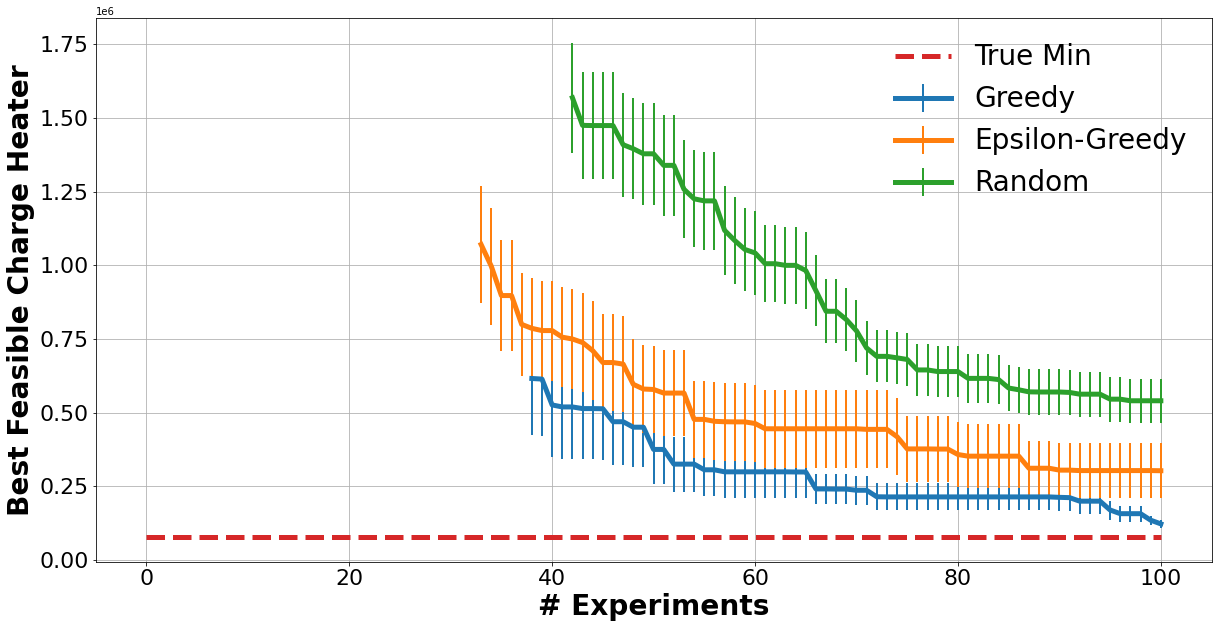

In [30]:
min_ron = 83
min_yield = 98
valid_comb_ix =(df['process_ron'] >= min_ron) & (df['process_yield'] >= min_yield)
paths = [("Greedy", "traces/greedy_83_99.csv"), ("Epsilon-Greedy", "traces/eg_83_99.csv"), ("Random", "traces/random.csv")]

f, ax = plt.subplots(1, 1, figsize=(20, 10))
for name,p in paths:
    tdf = np.array(pd.read_csv(p).set_index("Unnamed: 0"))
    
    trace_chs = []
    for r in tdf:
        sdf = df.iloc[r]
        fix = (sdf['process_ron'] >= min_ron) & (sdf['process_yield'] >= min_yield)
        chs = np.array(sdf['r1_charge_heater'])
        chs[~fix] = np.inf
        trace_chs.append(np.minimum.accumulate(chs))
    mean_trace = np.mean(trace_chs, axis=0)
    stderr_trace = np.std(trace_chs, axis=0, ddof=1) / np.sqrt(len(trace_chs))
    
    ax.errorbar(np.arange(mean_trace.shape[0]), mean_trace, yerr=stderr_trace, linewidth=5, label=name, marker='o', markersize=2, elinewidth=2)
    #ax.plot(, )

ax.plot(np.arange(mean_trace.shape[0]), np.ones(mean_trace.shape[0]) * 
        np.min(df[valid_comb_ix]['r1_charge_heater']), linewidth=5, linestyle='--', label='True Min')
ax.tick_params(axis='x', labelsize=22)
ax.tick_params(axis='y', labelsize=22)
ax.set_xlabel('# Experiments', fontsize=28, fontweight='bold')
ax.set_ylabel('Best Feasible Charge Heater', fontsize=28, fontweight='bold')
ax.grid(True)
ax.legend(fontsize=28, frameon=False)

In [28]:
np.min(df[(df['process_ron'] >= 83) & (df['process_yield'] >= 99)]['r1_charge_heater'])

3309702.58311608